In [5]:
import pandas as pd

# Load the dataset
train_path = r"C:\Users\90552\Downloads\archive (1)\DailyDelhiClimateTrain.csv"
test_path = r"C:\Users\90552\Downloads\archive (1)\DailyDelhiClimateTest.csv"

# Load the CSV file
df1 = pd.read_csv(train_path)
df2 = pd.read_csv(test_path)
data = pd.concat([df1, df2], ignore_index=True)
data.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [7]:
df = data.set_index('date')[['meantemp']]

In [9]:
df.head()

,meantemp
date,
2013-01-01,10.000000
2013-01-02,7.400000
2013-01-03,7.166667
2013-01-04,8.666667
2013-01-05,6.000000


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
train_size = 0.8
validate_size = 0.1
test_size = 0.1

train_data, temp_data = train_test_split(df, train_size=train_size, shuffle=False)
validate_data, test_data = train_test_split(temp_data, test_size=test_size / (validate_size + test_size), shuffle=False)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data only and transform the splits
train_data['meantemp'] = scaler.fit_transform(train_data[['meantemp']])
validate_data['meantemp'] = scaler.transform(validate_data[['meantemp']])
test_data['meantemp'] = scaler.transform(test_data[['meantemp']])

# Output the sizes of the splits
print(f"Train size: {train_data.shape}")
print(f"Validate size: {validate_data.shape}")
print(f"Test size: {test_data.shape}")

# Display the training data
print(train_data.head())

Train size: (1260, 1)
Validate size: (158, 1)
Test size: (158, 1)
            meantemp
date                
2013-01-01 -2.014442
2013-01-02 -2.360247
2013-01-03 -2.391281
2013-01-04 -2.191778
2013-01-05 -2.546450


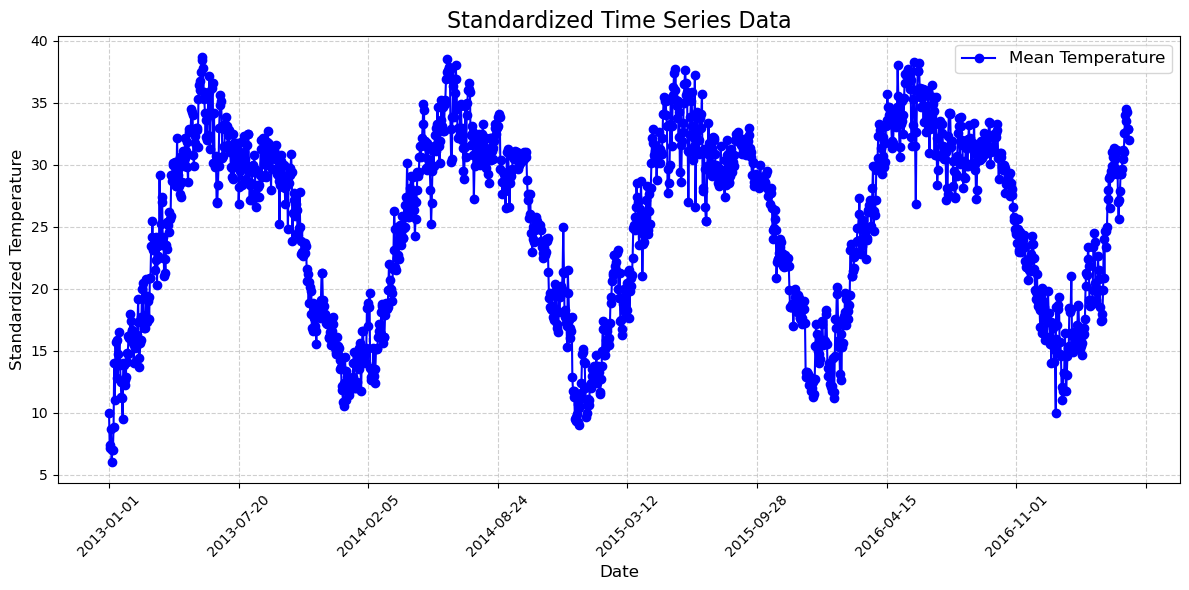

In [13]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Assuming the DataFrame is already preprocessed
# df['date'] is the index and df['meantemp'] is scaled

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['meantemp'], marker='o', linestyle='-', color='b', label='Mean Temperature')

# Improve x-axis labels
plt.title('Standardized Time Series Data', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Standardized Temperature', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.xticks(rotation=45)  # Rotate labels
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Reduce the number of ticks
plt.tight_layout()

plt.show()


In [14]:
import numpy as np

def create_sequences(data, sequence_length):
    """
    Converts a time series into sequences for LSTM input.
    
    Parameters:
        data (array-like): The time series data (1D array or DataFrame column).
        sequence_length (int): The number of time steps in each sequence.
        
    Returns:
        X, y: Arrays of input sequences (X) and corresponding outputs (y).
    """
    X, y = [], []
    for i in range(len(data) - sequence_length):
        # Extract a sequence of 'sequence_length' steps
        seq = data[i:i + sequence_length]
        # The output is the step immediately following the sequence
        label = data[i + sequence_length]
        X.append(seq)
        y.append(label)
    
    return np.array(X), np.array(y)

# Example usage:
sequence_length = 10  # Example sequence length
X_train, y_train = create_sequences(train_data['meantemp'].values, sequence_length)
X_validate, y_validate = create_sequences(validate_data['meantemp'].values, sequence_length)
X_test, y_test = create_sequences(test_data['meantemp'].values, sequence_length)

# Print shapes
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")


X_train shape: (1250, 10)
y_train shape: (1250,)


In [70]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout

# Define the LSTM model
model = Sequential([
    Input(shape=(X_train.shape[1], 1)),  # Input layer with sequence length and one feature
    LSTM(128, return_sequences=True),    # First LSTM layer
    Dropout(0.2),  # Dropout to prevent overfitting
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32, return_sequences=False),   
    Dropout(0.2),
    Dense(1)                            # Output layer for price prediction
])

# Compile the model with MSE loss and Adam optimizer
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_validate, y_validate),
    epochs=50,       # Increase this if results improve steadily
    batch_size=32,
    verbose=1
)


Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step - loss: 0.4085 - mae: 0.5044 - val_loss: 0.1023 - val_mae: 0.2572
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.1392 - mae: 0.3001 - val_loss: 0.0709 - val_mae: 0.2176
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.1208 - mae: 0.2758 - val_loss: 0.0668 - val_mae: 0.2084
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.1062 - mae: 0.2587 - val_loss: 0.0758 - val_mae: 0.2178
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.1169 - mae: 0.2705 - val_loss: 0.0661 - val_mae: 0.2045
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.1003 - mae: 0.2524 - val_loss: 0.0617 - val_mae: 0.1964
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.1016 - mae: 0.2533 - val_loss: 0.0601 - val_mae: 0.1918
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0969 - mae: 0.2442 - val_loss: 0.0605 - val_mae: 0.1942
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.09

In [75]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Make predictions on the test set
predictions = model.predict(X_test)

# Inverse transform predictions and true values
predictions = scaler.inverse_transform(predictions)
test_y_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate metrics
rmse = np.sqrt(mean_squared_error(test_y_actual, predictions))
mae = mean_absolute_error(test_y_actual, predictions)
r2 = r2_score(test_y_actual, predictions)

print(f"RMSE: {rmse}, MAE: {mae}, R^2: {r2}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
RMSE: 0.2384314850550565, MAE: 0.18780752900217512, R^2: 0.9124993130549324


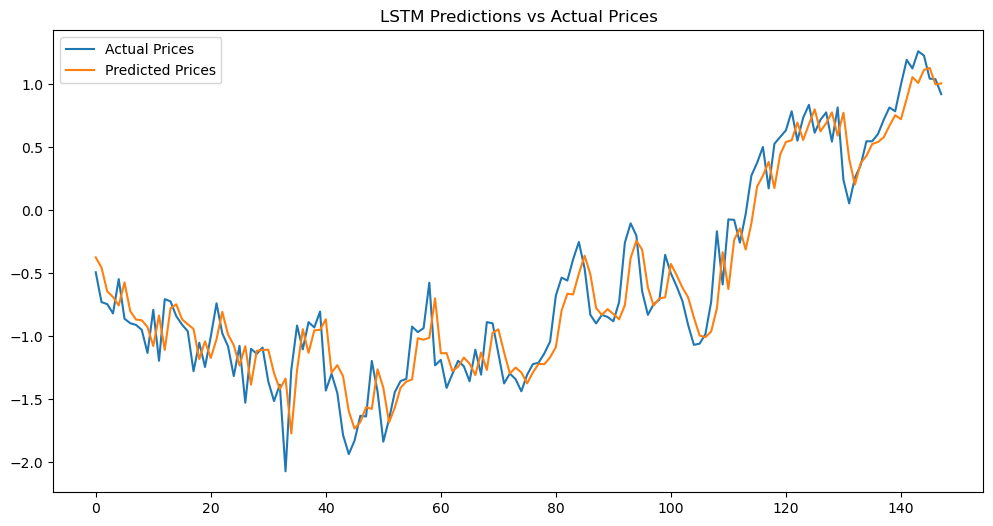

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(test_y_actual, label='Actual Prices')
plt.plot(predictions, label='Predicted Prices')
plt.legend()
plt.title("LSTM Predictions vs Actual Prices")
plt.show()